## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:01<00:00, 14932294.44it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274131.75it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5102917.37it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12116878.22it/s]


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [44]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=512, dropout_rate=0.2, hidden_size_2=128):
        super(TinyNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [45]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 128]          65,664
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 470,154
Trainable params: 470,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.79
Estimated Total Size (MB): 1.82
-------------------------------------------

Your experiments come here:

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the selected device
model = TinyNeuralNetwork().to(device)

# Choose an optimizer and a loss function
optimizer = torch.optim.Adagrad(model.parameters(), lr=3e-3)
loss_function = nn.CrossEntropyLoss()

# Training loop
num_epochs = 9
for epoch in range(num_epochs):
    model.train()
    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = loss_function(outputs, batch_labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs = model(batch_data)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.4f}')

print("Training finished.")


Epoch 1/9, Loss: 0.4944, Test Accuracy: 0.8510
Epoch 2/9, Loss: 0.5483, Test Accuracy: 0.8684
Epoch 3/9, Loss: 0.3498, Test Accuracy: 0.8738
Epoch 4/9, Loss: 0.2549, Test Accuracy: 0.8811
Epoch 5/9, Loss: 0.2215, Test Accuracy: 0.8805
Epoch 6/9, Loss: 0.2076, Test Accuracy: 0.8812
Epoch 7/9, Loss: 0.3482, Test Accuracy: 0.8804
Epoch 8/9, Loss: 0.2949, Test Accuracy: 0.8868
Epoch 9/9, Loss: 0.2792, Test Accuracy: 0.8905
Training finished.


Ё
### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Epoch 1/10, Overfitting Train Loss: 0.4145, Overfitting Test Loss: 0.8552, Overfitting Train Accuracy: 0.8458, Overfitting Test Accuracy: 0.7213
Epoch 2/10, Overfitting Train Loss: 0.3237, Overfitting Test Loss: 0.7325, Overfitting Train Accuracy: 0.8801, Overfitting Test Accuracy: 0.7556
Epoch 3/10, Overfitting Train Loss: 0.2947, Overfitting Test Loss: 0.8100, Overfitting Train Accuracy: 0.8898, Overfitting Test Accuracy: 0.6781
Epoch 4/10, Overfitting Train Loss: 0.2803, Overfitting Test Loss: 0.8962, Overfitting Train Accuracy: 0.8932, Overfitting Test Accuracy: 0.7339
Epoch 5/10, Overfitting Train Loss: 0.2885, Overfitting Test Loss: 0.9636, Overfitting Train Accuracy: 0.8911, Overfitting Test Accuracy: 0.6422
Epoch 6/10, Overfitting Train Loss: 0.2432, Overfitting Test Loss: 0.8981, Overfitting Train Accuracy: 0.9088, Overfitting Test Accuracy: 0.6655
Epoch 7/10, Overfitting Train Loss: 0.2209, Overfitting Test Loss: 1.2894, Overfitting Train Accuracy: 0.9153, Overfitting Test Ac

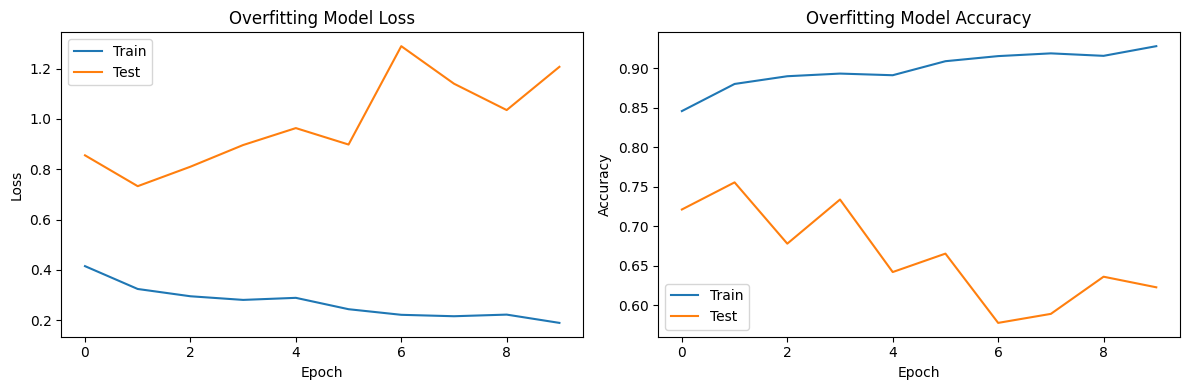

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Load Fashion-MNIST dataset and Decrease the size of the train dataset to enforce overfitting
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
fmnist_dataset_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
overfitting_train_loader = DataLoader(fmnist_dataset_train, batch_size=32, shuffle=True, num_workers=2)

# Define a neural network for overfitting
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=512, dropout_rate=0.0, hidden_size_2=512):
        super(OverfittingNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, hidden_size),
            #nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, hidden_size_2),
            #nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the overfitting model and move it to the selected device
overfitting_model = OverfittingNeuralNetwork().to(device)

# Choose an optimizer and a loss function
optimizer_overfitting = torch.optim.Adam(overfitting_model.parameters(), lr=0.001)
criterion_overfitting = nn.CrossEntropyLoss()

# Training loop for overfitting
num_epochs_overfitting = 10
overfitting_train_losses = []
overfitting_test_losses = []
overfitting_train_accuracies = []
overfitting_test_accuracies = []

for epoch in range(num_epochs_overfitting):
    overfitting_model.train()
    for batch_data, batch_labels in overfitting_train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        optimizer_overfitting.zero_grad()
        outputs_overfitting = overfitting_model(batch_data)
        loss_overfitting = criterion_overfitting(outputs_overfitting, batch_labels)
        loss_overfitting.backward()
        optimizer_overfitting.step()

    # Train set evaluation
    overfitting_model.eval()
    overfitting_train_loss = 0.0
    correct_train, total_train = 0, 0
    with torch.no_grad():
        for batch_data, batch_labels in overfitting_train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs_overfitting = overfitting_model(batch_data)
            _, predicted_train = torch.max(outputs_overfitting, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted_train == batch_labels).sum().item()
            overfitting_train_loss += criterion_overfitting(outputs_overfitting, batch_labels).item()

    # Test set evaluation
    overfitting_test_loss = 0.0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs_overfitting = overfitting_model(batch_data)
            _, predicted_test = torch.max(outputs_overfitting, 1)
            total_test += batch_labels.size(0)
            correct_test += (predicted_test == batch_labels).sum().item()
            overfitting_test_loss += criterion_overfitting(outputs_overfitting, batch_labels).item()

    # Calculate average losses and accuracies
    overfitting_train_losses.append(overfitting_train_loss / len(overfitting_train_loader))
    overfitting_test_losses.append(overfitting_test_loss / len(test_loader))
    overfitting_train_accuracies.append(correct_train / total_train)
    overfitting_test_accuracies.append(correct_test / total_test)

    print(f'Epoch {epoch+1}/{num_epochs_overfitting}, '
          f'Overfitting Train Loss: {overfitting_train_losses[-1]:.4f}, '
          f'Overfitting Test Loss: {overfitting_test_losses[-1]:.4f}, '
          f'Overfitting Train Accuracy: {overfitting_train_accuracies[-1]:.4f}, '
          f'Overfitting Test Accuracy: {overfitting_test_accuracies[-1]:.4f}')

# Plotting the loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(overfitting_train_losses, label='Train')
plt.plot(overfitting_test_losses, label='Test')
plt.title('Overfitting Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(overfitting_train_accuracies, label='Train')
plt.plot(overfitting_test_accuracies, label='Test')
plt.title('Overfitting Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Epoch 1/9, Train Loss: 0.3744, Test Loss: 0.4229, Train Accuracy: 0.8651, Test Accuracy: 0.8477
Epoch 2/9, Train Loss: 0.3037, Test Loss: 0.3618, Train Accuracy: 0.8881, Test Accuracy: 0.8631
Epoch 3/9, Train Loss: 0.3001, Test Loss: 0.3698, Train Accuracy: 0.8863, Test Accuracy: 0.8568
Epoch 4/9, Train Loss: 0.2399, Test Loss: 0.3153, Train Accuracy: 0.9111, Test Accuracy: 0.8848
Epoch 5/9, Train Loss: 0.2374, Test Loss: 0.3247, Train Accuracy: 0.9109, Test Accuracy: 0.8801
Epoch 6/9, Train Loss: 0.2169, Test Loss: 0.3108, Train Accuracy: 0.9184, Test Accuracy: 0.8873
Epoch 7/9, Train Loss: 0.2480, Test Loss: 0.3541, Train Accuracy: 0.9033, Test Accuracy: 0.8663
Epoch 8/9, Train Loss: 0.1936, Test Loss: 0.3061, Train Accuracy: 0.9271, Test Accuracy: 0.8911
Epoch 9/9, Train Loss: 0.1866, Test Loss: 0.3030, Train Accuracy: 0.9308, Test Accuracy: 0.8890


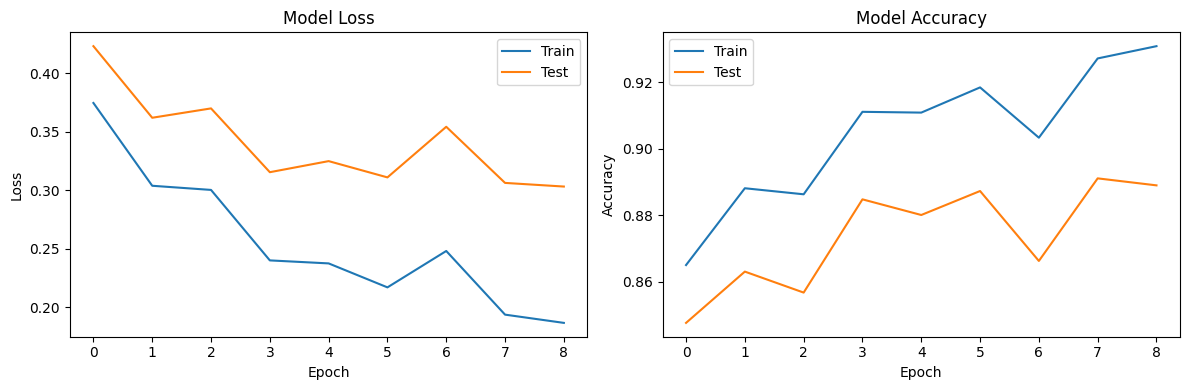

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a neural network for overfitting
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=512, dropout_rate=0.2, hidden_size_2=128):
        super(OverfittingNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the overfitting model and move it to the selected device
overfitting_model = OverfittingNeuralNetwork().to(device)

# Choose an optimizer and a loss function
optimizer_overfitting = torch.optim.Adam(overfitting_model.parameters(), lr=0.001)
criterion_overfitting = nn.CrossEntropyLoss()

# Training loop for overfitting
num_epochs_overfitting = 9
overfitting_train_losses = []
overfitting_test_losses = []
overfitting_train_accuracies = []
overfitting_test_accuracies = []

for epoch in range(num_epochs_overfitting):
    overfitting_model.train()
    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        optimizer_overfitting.zero_grad()
        outputs_overfitting = overfitting_model(batch_data)
        loss_overfitting = criterion_overfitting(outputs_overfitting, batch_labels)
        loss_overfitting.backward()
        optimizer_overfitting.step()

    # Train set evaluation
    overfitting_model.eval()
    overfitting_train_loss = 0.0
    correct_train, total_train = 0, 0
    with torch.no_grad():
        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs_overfitting = overfitting_model(batch_data)
            _, predicted_train = torch.max(outputs_overfitting, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted_train == batch_labels).sum().item()
            overfitting_train_loss += criterion_overfitting(outputs_overfitting, batch_labels).item()

    # Test set evaluation
    overfitting_test_loss = 0.0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs_overfitting = overfitting_model(batch_data)
            _, predicted_test = torch.max(outputs_overfitting, 1)
            total_test += batch_labels.size(0)
            correct_test += (predicted_test == batch_labels).sum().item()
            overfitting_test_loss += criterion_overfitting(outputs_overfitting, batch_labels).item()

    # Calculate average losses and accuracies
    overfitting_train_losses.append(overfitting_train_loss / len(train_loader))
    overfitting_test_losses.append(overfitting_test_loss / len(test_loader))
    overfitting_train_accuracies.append(correct_train / total_train)
    overfitting_test_accuracies.append(correct_test / total_test)

    print(f'Epoch {epoch+1}/{num_epochs_overfitting}, '
          f'Train Loss: {overfitting_train_losses[-1]:.4f}, '
          f'Test Loss: {overfitting_test_losses[-1]:.4f}, '
          f'Train Accuracy: {overfitting_train_accuracies[-1]:.4f}, '
          f'Test Accuracy: {overfitting_test_accuracies[-1]:.4f}')

# Plotting the loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(overfitting_train_losses, label='Train')
plt.plot(overfitting_test_losses, label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(overfitting_train_accuracies, label='Train')
plt.plot(overfitting_test_accuracies, label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._